## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

## Useful functions

### Utility functions

In [2]:
def draw_images(image_list, title_list, width = 5):
    assert len(image_list) == len(title_list)
    n = len(image_list)
    plt.figure(figsize=(n*width,width))
    for i in range(len(image_list)):
        plt.subplot(1,n,i+1)
        plt.axis('off')
        plt.title(title_list[i])
        plt.imshow(image_list[i])
    plt.show()

### Distortion correction

In [3]:
### Compute object points and image points

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        # img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # cv2.imshow('img',img)
        # cv2.waitKey(500)
        
ret, MTX, DIST, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

def undistort(distorted):
    return cv2.undistort(distorted, MTX, DIST, None, MTX)

In [4]:
def draw_lanes(undist,warped,ploty,left_fitx,right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    plt.imshow(result)

## Undistort an image

### Chess board image

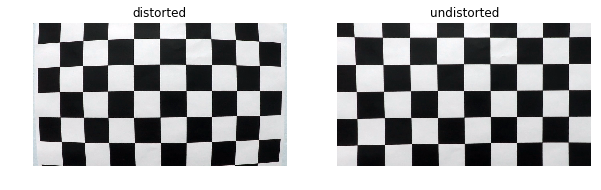

In [5]:
distorted_img = cv2.imread('../camera_cal/calibration1.jpg')
undistorted_img = undistort(distorted_img)
draw_images([distorted_img, undistorted_img],['distorted','undistorted'])

### Undistorting a test image

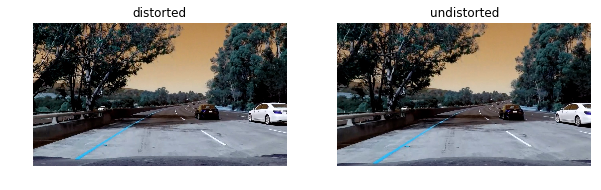

In [6]:
distorted_test_img = cv2.imread('../test_images/test5.jpg')
undistorted_test_img = undistort(distorted_test_img)
draw_images([distorted_test_img, undistorted_test_img],['distorted','undistorted'])

### Perspective transform

#### Define area of interest

In [7]:
def get_warp_points(imshape):
    offsetx = 100
    offsety = 30
    src = np.float32([
        [2*offsetx,imshape[0]],# Top right
        [imshape[1]/2-offsetx+offsety, imshape[0]/2+offsetx],# Bottom right
        [imshape[1]/2+offsetx-offsety, imshape[0]/2+offsetx],# Bottom left
        [imshape[1]-offsetx/2,imshape[0]]# Top left
    ])
    dst = np.float32([
        [offsetx,imshape[0]],# Top right
        [offsetx,0],# Bottom right
        [imshape[1]-offsetx,0],# Bottom left
        [imshape[1]-offsetx,imshape[0]]# Top left
        ])
    return src, dst

#### Warp/transform image

In [8]:
def warp(image):
    image_size = image.shape[1], image.shape[0]
    src, dst = get_warp_points(image.shape)
    M = cv2.getPerspectiveTransform(src,dst)
    warped = cv2.warpPerspective(image, M, image_size, flags = cv2.INTER_LINEAR)
    return warped

### Gradient and Threshold

In [9]:
def threshold(image, s_thresh=(170, 255), sx_thresh=(30, 120)):
    img = np.copy(image)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
    abs_sobelx = np.absolute(sobelx) 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary   

### Sliding Windows search

In [10]:
def sliding_window(binary_warped, visualize = False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #left_fit, right_fit, out_img = sliding_window(binary_warped)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    lcurve, rcurve = get_curvature(binary_warped, ploty, leftx, lefty, rightx, righty)
    center_pos = get_center_pos(binary_warped, left_fitx, right_fitx)
    if(visualize):
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    return left_fit, right_fit, lcurve, rcurve, center_pos

### Road curvature and vehicle position

In [11]:
def get_curvature(image, ploty, leftx, lefty, rightx, righty):
    y_eval = image.shape[0]
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])
    # Now our radius of curvature is in meters
    # print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad, right_curverad

def get_center_pos(image, left_fitx, right_fitx):
    xm_per_pix = 3.7 / 700
    center_pos = (image.shape[1]/2.0 - (left_fitx[-1]+right_fitx[-1])/2.0)*xm_per_pix
    return center_pos

### Image processing pipeline

In [12]:
def getXY(binary_warped, left_fit, right_fit):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx

def warp_back(image, warped, left_fit, right_fit):
    ploty, left_fitx, right_fitx = getXY(warped, left_fit, right_fit) 
    src_warp, dst_warp = get_warp_points(image.shape)
    Minv = cv2.getPerspectiveTransform(dst_warp,src_warp)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result
    
def pipeline(image, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(image)
    img = undistort(img)
    combined_binary = threshold(img)
    warped = warp(combined_binary)
    left_fit, right_fit, lcurve, rcurve, center_pos = sliding_window(warped, False)
    image_with_lane_lines = warp_back(img, warped, left_fit, right_fit)
    curvature = (lcurve + rcurve)/2.0
    if center_pos <= 0:
        disp_text = 'Radius of curvature is {:.2f} m, Vehicle {:.2f} left of center'.format(curvature, abs(center_pos))
    else:
        disp_text = 'Radius of curvature is {:.2f} m, Vehicle {:.2f} right of center'.format(curvature, abs(center_pos))
    cv2.putText(image_with_lane_lines,disp_text,(100,100),cv2.FONT_HERSHEY_PLAIN,2,(255,255,255),1)
    return image_with_lane_lines

### Testing pipeline on single image

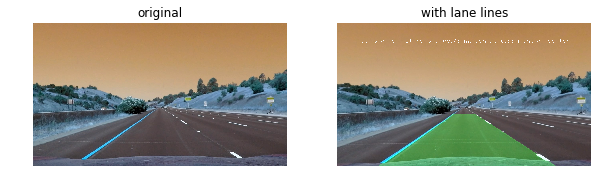

In [13]:
image = cv2.imread('../test_images/straight_lines1.jpg')
warped_lane_lines = pipeline(image)
draw_images([image,warped_lane_lines],['original','with lane lines'])

## Video

In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = '../output_images/video_output_final.mp4'
clip1 = VideoFileClip("../project_video.mp4")
last_good_line = {}
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ../output_images/video_output_final.mp4
[MoviePy] Writing video ../output_images/video_output_final.mp4


100%|█████████▉| 1260/1261 [03:02<00:00,  6.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_images/video_output_final.mp4 

CPU times: user 3min 10s, sys: 37.4 s, total: 3min 48s
Wall time: 3min 3s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))